# US Baby Names 1880-2010

There are many things you might want to do with the dataset:

- Visualize the proportion of babies given a particular name (your own, or another name) over time

- Determine the relative rank of a name

- Determine the most popular names in each year or the names whose popularity has advanced or declined the most

- Analyze trends in names: vowels, consonants, length, overall diversity, changes in spelling, first and last letters

- Analyze external sources of trends: biblical names, celebrities, demographics

### Imports

In [40]:
from collections import defaultdict, Counter
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# use the Unix head command to look at the first 10 lines of one of the files 
!head -n 10 datasets/babynames/yob1880.txt

Mary,F,7065
Anna,F,2604
Emma,F,2003
Elizabeth,F,1939
Minnie,F,1746
Margaret,F,1578
Ida,F,1472
Alice,F,1414
Bertha,F,1320
Sarah,F,1288


In [3]:
names1880 = pd.read_csv("datasets/babynames/yob1880.txt", names=["name", "sex", "births"])
names1880

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
...,...,...,...
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5


In [4]:
names1880.groupby("sex")["births"].sum()

sex
F     90993
M    110493
Name: births, dtype: int64

*Since the dataset is split into files by year, one of the first things to do is to assemble all of the data into a single DataFrame and further add a `year` field. You can do this using `pandas.concat`*

In [6]:
pieces = []
for year in range(1880, 2011):
    path = f"datasets/babynames/yob{year}.txt"
    frame = pd.read_csv(path, names=["name", "sex", "births"])

    # Add a column for the year
    frame["year"] = year
    pieces.append(frame)

# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)

*There are a couple things to note here. First, remember that `concat` combines the DataFrame objects by row by default. Second, you have to pass `ignore_index=True` because we’re not interested in preserving the original row numbers returned from `pandas.read_csv`*

In [7]:
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1690779,Zymaire,M,5,2010
1690780,Zyonne,M,5,2010
1690781,Zyquarius,M,5,2010
1690782,Zyran,M,5,2010


In [8]:
total_births = names.pivot_table("births", index="year", columns="sex", aggfunc=sum)

total_births.tail()

sex,F,M
year,,
2006,1896468,2050234
2007,1916888,2069242
2008,1883645,2032310
2009,1827643,1973359
2010,1759010,1898382


<Axes: title={'center': 'Total births by sex and year'}, xlabel='year'>

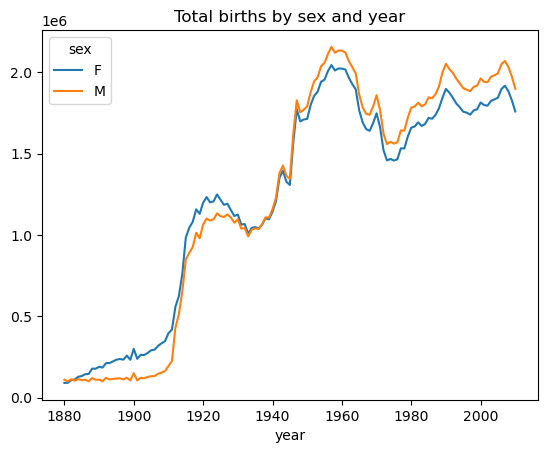

In [9]:
total_births.plot(title="Total births by sex and year")

*Next, let’s insert a column `prop` with the fraction of babies given each name relative to the total number of births. A `prop` value of `0.02` would indicate that 2 out of every 100 babies were given a particular name. Thus, we group the data by year and sex, then add the new column to each group*

In [11]:
def add_prop(group):
    group["prop"] = group["births"] / group["births"].sum()
    return group

names = names.groupby(["year", "sex"], group_keys=False).apply(add_prop)
names

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1690779,Zymaire,M,5,2010,0.000003
1690780,Zyonne,M,5,2010,0.000003
1690781,Zyquarius,M,5,2010,0.000003
1690782,Zyran,M,5,2010,0.000003


*When performing a group operation like this, it's often valuable to do a sanity check, like verifying that the `prop` column sums to 1 within all the groups*

In [12]:
names.groupby(["year","sex"])["prop"].sum()

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2008  M      1.0
2009  F      1.0
      M      1.0
2010  F      1.0
      M      1.0
Name: prop, Length: 262, dtype: float64

In [16]:
def get_top1000(group):
    return group.sort_values("births", ascending=False)[:1000]

grouped = names.groupby(["year", "sex"])
top1000 = grouped.apply(get_top1000)
top1000.head()

name sex  births  year      prop
year sex                                         
1880 F   0       Mary   F    7065  1880  0.077643
         1       Anna   F    2604  1880  0.028618
         2       Emma   F    2003  1880  0.022013
         3  Elizabeth   F    1939  1880  0.021309
         4     Minnie   F    1746  1880  0.019188

In [18]:
top1000 = top1000.reset_index(drop=True)
top1000.head()

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188


## Analyzing Naming Trends

In [19]:
boys = top1000[top1000["sex"] == "M"]

girls = top1000[top1000["sex"] == "F"]

In [20]:
total_births = top1000.pivot_table("births", index="year", columns="name", aggfunc=sum)

total_births.info()

<class 'pandas.core.frame.DataFrame'>
Index: 131 entries, 1880 to 2010
Columns: 6868 entries, Aaden to Zuri
dtypes: float64(6868)
memory usage: 6.9 MB


array([<Axes: xlabel='year'>, <Axes: xlabel='year'>,
       <Axes: xlabel='year'>, <Axes: xlabel='year'>], dtype=object)

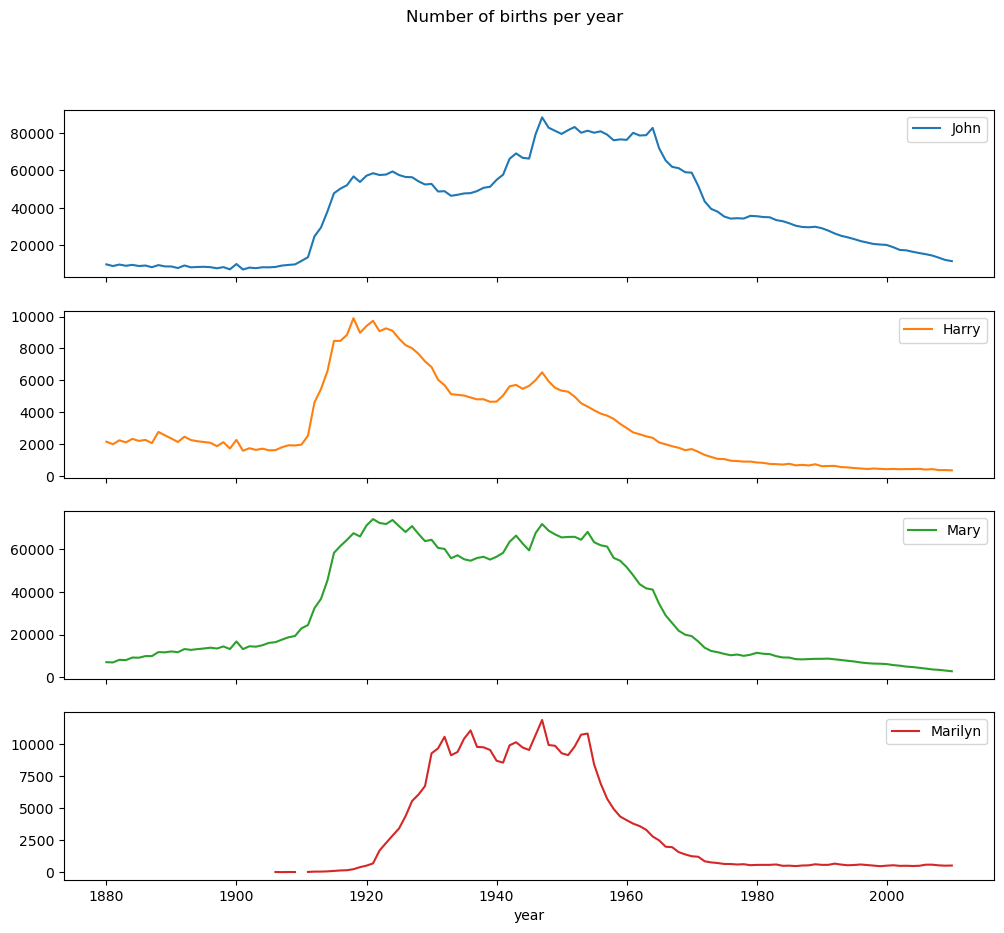

In [21]:
subset = total_births[["John", "Harry", "Mary", "Marilyn"]]

subset.plot(subplots=True, figsize=(12,10), title="Number of births per year")

*On looking at this, you might conclude that these names have grown out of favor with the American population. But the story is actually more complicated than that, as will be explored in the next section.*

### Measuring the increase in naming diversity


<Axes: title={'center': 'Sum of table1000.prop by year and sex'}, xlabel='year'>

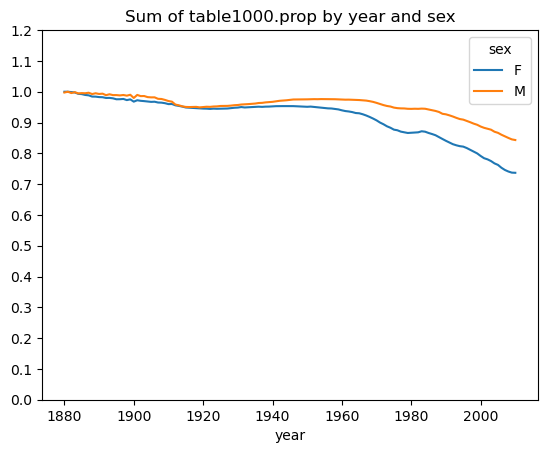

In [22]:
table = top1000.pivot_table("prop", index="year", columns="sex", aggfunc=sum)

table.plot(title="Sum of table1000.prop by year and sex", yticks=np.linspace(0, 1.2, 13))

*You can see that, indeed, there appears to be increasing name diversity (decreasing total proportion in the top one thousand). Another interesting metric is the number of distinct names, taken in order of popularity from highest to lowest, in the top 50% of births. This number is trickier to compute. Let’s consider just the boy names from 2010*

In [23]:
df = boys[boys["year"] == 2010]
df

,name,sex,births,year,prop
260877,Jacob,M,21875,2010,0.011523
260878,Ethan,M,17866,2010,0.009411
260879,Michael,M,17133,2010,0.009025
260880,Jayden,M,17030,2010,0.008971
260881,William,M,16870,2010,0.008887
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


After sorting `prop` in descending order, we want to know how many of the most popular names it takes to reach 50%. You could write a `for` loop to do this, but a vectorized NumPy way is more computationally efficient. Taking the cumulative sum, `cumsum`, of `prop` and then calling the method `searchsorted` returns the position in the cumulative sum at which `0.5` would need to be inserted to keep it in sorted order

In [24]:
prop_cumsum = df["prop"].sort_values(ascending=False).cumsum()

prop_cumsum[:10]

260877    0.011523
260878    0.020934
260879    0.029959
260880    0.038930
260881    0.047817
260882    0.056579
260883    0.065155
260884    0.073414
260885    0.081528
260886    0.089621
Name: prop, dtype: float64

In [28]:
prop_cumsum.searchsorted(0.5)+1

117

In [30]:
df = boys[boys.year == 1900]
in1900 = df.sort_values("prop", ascending=False).prop.cumsum()
in1900.searchsorted(0.5) + 1

25

*You can now apply this operation to each year/sex combination, `groupby` those fields, and `apply` a function returning the count for each group:*

In [31]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values("prop", ascending=False)
    return group.prop.cumsum().searchsorted(q) + 1


diversity = top1000.groupby(["year", "sex"]).apply(get_quantile_count)
diversity = diversity.unstack()

*This resulting DataFrame `diversity` now has two time series, one for each sex, indexed by year.*

sex    F   M
year        
1880  38  14
1881  38  14
1882  38  15
1883  39  15
1884  39  16


<Axes: title={'center': 'Number of popular names in top 50%'}, xlabel='year'>

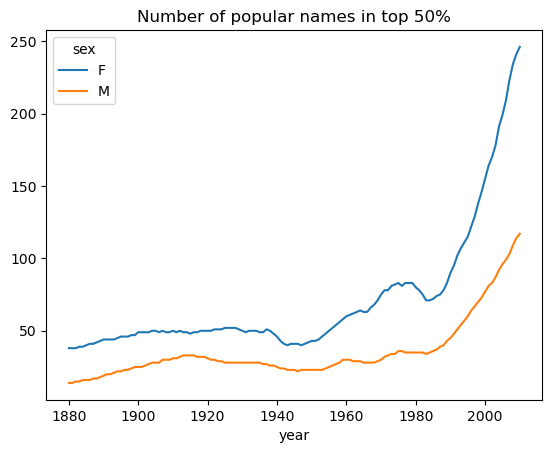

In [34]:
print(diversity.head())

diversity.plot(title="Number of popular names in top 50%")

*As you can see, girl names have always been more diverse than boy names, and they have only become more so over time. Further analysis of what exactly is driving the diversity, like the increase of alternative spellings, is left to the reader.*

### The "last letter" revolution

*In 2007, baby name researcher Laura Wattenberg pointed out that the distribution of boy names by final letter has changed significantly over the last 100 years. *

In [36]:
def get_last_letter(x):
    return x[-1]


last_letters = names["name"].map(get_last_letter)
last_letters.name = "last_letter"

table = names.pivot_table("births", index=last_letters, columns=["sex", "year"], aggfunc=sum)

In [37]:
subtable = table.reindex(columns=[1910, 1960, 2010], level="year")
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

In [38]:
subtable.sum()

sex  year
F    1910     396416.0
     1960    2022062.0
     2010    1759010.0
M    1910     194198.0
     1960    2132588.0
     2010    1898382.0
dtype: float64

In [39]:
letter_prop = subtable/subtable.sum()
letter_prop

sex                 F                             M                    
year             1910      1960      2010      1910      1960      2010
last_letter                                                            
a            0.273390  0.341853  0.381240  0.005031  0.002440  0.014980
b                 NaN  0.000343  0.000256  0.002116  0.001834  0.020470
c            0.000013  0.000024  0.000538  0.002482  0.007257  0.012181
d            0.017028  0.001844  0.001482  0.113858  0.122908  0.023387
e            0.336941  0.215133  0.178415  0.147556  0.083853  0.067959
f                 NaN  0.000010  0.000055  0.000783  0.004325  0.001188
g            0.000144  0.000157  0.000374  0.002250  0.009488  0.001404
h            0.051529  0.036224  0.075852  0.045562  0.037907  0.051670
i            0.001526  0.039965  0.031734  0.000844  0.000603  0.022628
j                 NaN       NaN  0.000090       NaN       NaN  0.000769
k            0.000121  0.000156  0.000356  0.036581  0.049384  0.018541
l            0.043189  0.033867  0.026356  0.065016  0.104904  0.070367
m            0.001201  0.008613  0.002588  0.058044  0.033827  0.024657
n            0.079240  0.130687  0.140210  0.143415  0.152522  0.362771
o            0.001660  0.002439  0.001243  0.017065  0.012829  0.042681
p            0.000018  0.000023  0.000020  0.003172  0.005675  0.001269
q                 NaN       NaN  0.000030       NaN       NaN  0.000180
r            0.013390  0.006764  0.018025  0.064481  0.031034  0.087477
s            0.039042  0.012764  0.013332  0.130815  0.102730  0.065145
t            0.027438  0.015201  0.007830  0.072879  0.065655  0.022861
u            0.000684  0.000574  0.000417  0.000124  0.000057  0.001221
v                 NaN  0.000060  0.000117  0.000113  0.000037  0.001434
w            0.000020  0.000031  0.001182  0.006329  0.007711  0.016148
x            0.000015  0.000037  0.000727  0.003965  0.001851  0.008614
y            0.110972  0.152569  0.116828  0.077349  0.160987  0.058168
z            0.002439  0.000659  0.000704  0.000170  0.000184  0.001831

<Axes: title={'center': 'Female'}, xlabel='last_letter'>

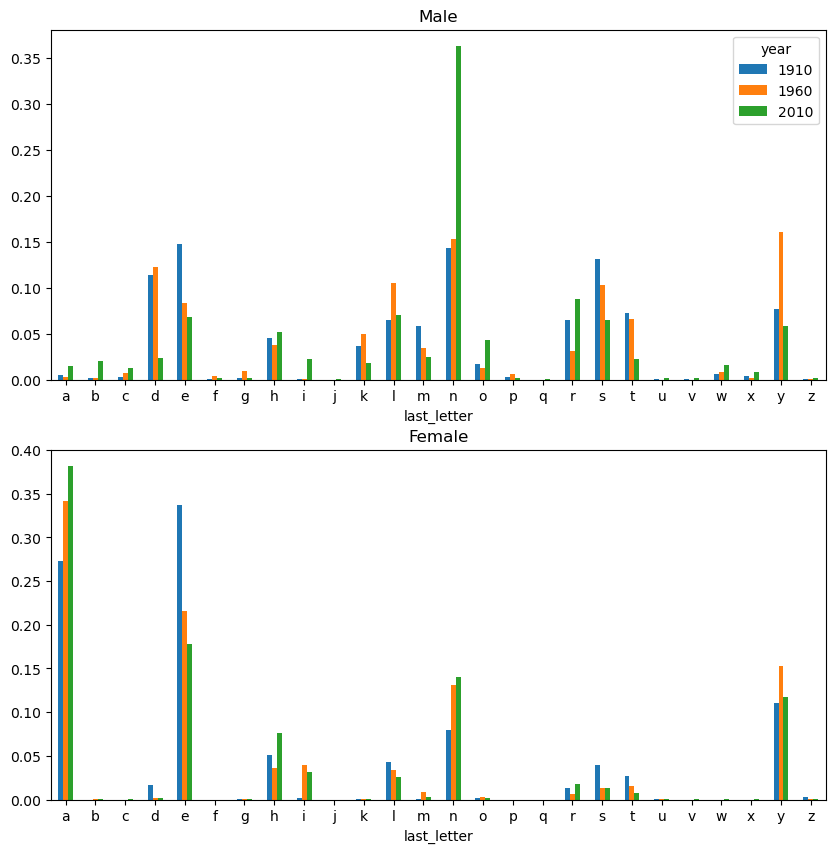

In [42]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))
letter_prop["M"].plot(kind="bar", rot=0, ax=axes[0], title="Male")
letter_prop["F"].plot(kind="bar", rot=0, ax=axes[1], title="Female", legend=False)

*As you can see, boy names ending in n have experienced significant growth since the 1960s. Going back to the full table created before, I again normalize by year and sex and select a subset of letters for the boy names, finally transposing to make each column a time series*

In [45]:
letter_prop = table / table.sum()

dny_ts = letter_prop.loc[["d","n","y"],"M"].T

dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405


<Axes: xlabel='year'>

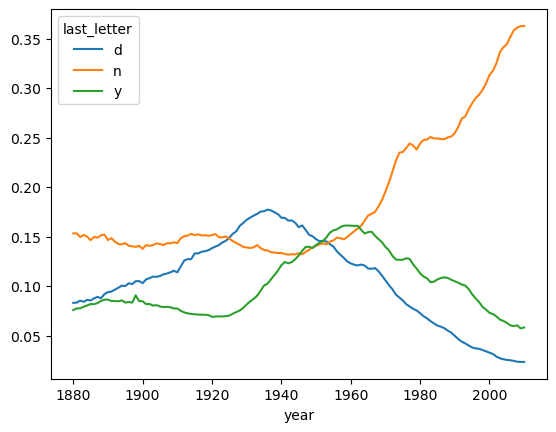

In [47]:
dny_ts.plot()
# Proportion of boys born with names ending in d/n/y over time

### Boy names that became girl names (and vice versa)


*Another fun trend is looking at names that were more popular with one gender earlier in the sample but have become preferred as a name for the other gender over time. One example is the name Lesley or Leslie. Going back to the `top1000` DataFrame, I compute a list of names occurring in the dataset starting with "Lesl"*

In [48]:
all_names = pd.Series(top1000["name"].unique())

lesley_like = all_names[all_names.str.contains("Lesl")]

lesley_like

632     Leslie
2294    Lesley
4262    Leslee
4728     Lesli
6103     Lesly
dtype: object

In [52]:
filtered = top1000[top1000["name"].isin(lesley_like)]
filtered.groupby("name")["births"].sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

In [55]:
table = filtered.pivot_table("births",index="year",columns="sex",aggfunc="sum")
table = table.div(table.sum(axis="columns"), axis="index")
table.tail()

sex,F,M
year,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


<Axes: xlabel='year'>

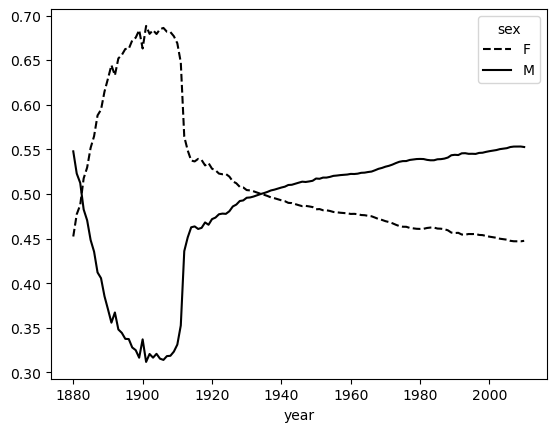

In [51]:
table.plot(style={"M": "k-", "F": "k--"})

*Proportion of male/female Lesley-like names over time*